<a href="https://colab.research.google.com/github/taufikfathonii/Analisa-Sentimen-Taufik/blob/main/Pemodelan_Sentimen_Analisis_Project_(%20Taufik%20).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ANALISIS SENTIMEN PENGGUNA TERHADAP WONDR BNI DI PLAY STORE**

#Instalasi Library


In [ ]:
!pip install sastrawi
!pip install tensorflow
!pip install scikit-learn
!pip install pandas nltk wordcloud requests matplotlib seaborn
!pip install lightgbm xgboost catboost
!pip install dask[dataframe]

#Impor Library


In [ ]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
import requests
import json
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
import time
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#Dataset

In [ ]:
df = pd.read_csv(r'/content/hasil_scraping_KAI Access.csv', encoding='utf-8', quotechar='"', escapechar='\\')
# Membaca file CSV dari URL ke dalam DataFrame pandas

df.head() # Menampilkan 5 baris pertama dari DataFrame

,content,score
0,Aplikasi KAI Acces sebelumnya lebih simple dan...,1
1,Alasan Rating: Tidak kompatibel dengan ponsel ...,3
2,"Habis di update makin parah, dah saldo berkura...",1
3,Entah kenapa appnya yg update terbaru sekarang...,1
4,Ini gimana mau pesan tiket susah bgt... OTP ma...,1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Cleaning

In [ ]:
clean_df = df.dropna()


In [ ]:
clean_df = clean_df.drop_duplicates()


In [ ]:
clean_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 70031 entries, 0 to 84041
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  70031 non-null  object
 1   score    70031 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


In [ ]:
clean_df.head()


,content,score
0,Aplikasi KAI Acces sebelumnya lebih simple dan...,1
1,Alasan Rating: Tidak kompatibel dengan ponsel ...,3
2,"Habis di update makin parah, dah saldo berkura...",1
3,Entah kenapa appnya yg update terbaru sekarang...,1
4,Ini gimana mau pesan tiket susah bgt... OTP ma...,1


#Pra-pemrosesan Teks (Text Preprocessing)

In [ ]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word.lower() not in ["Access", "KAI ", "mobile"]])
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku','di','ya','loh','kah','deh'])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

def fix_slangwords(text):
    words = text.split()
    fixed_words = []
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [ ]:
url = 'https://raw.githubusercontent.com/aninanandah/datasetproject/main/slangwords.json'

response = requests.get(url)

if response.status_code == 200:
    try:
        slangwords = json.loads(response.text)
    except json.JSONDecodeError as e:
        print("Error decoding JSON:", e)
        print("Response content:", response.text)
else:
    print("Failed to fetch data from URL. Status code:", response.status_code)


In [ ]:
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [ ]:
clean_df.head()


,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Aplikasi KAI Acces sebelumnya lebih simple dan...,1,Aplikasi KAI Acces sebelumnya lebih simple dan...,aplikasi kai acces sebelumnya lebih simple dan...,aplikasi kai acces sebelumnya lebih simple dan...,"[aplikasi, kai, acces, sebelumnya, lebih, simp...","[aplikasi, kai, acces, simple, langsung, lanca...",aplikasi kai acces simple langsung lancar sesu...
1,Alasan Rating: Tidak kompatibel dengan ponsel ...,3,Alasan Rating Tidak kompatibel dengan ponsel s...,alasan rating tidak kompatibel dengan ponsel s...,alasan rating tidak kompatibel dengan ponsel s...,"[alasan, rating, tidak, kompatibel, dengan, po...","[alasan, rating, kompatibel, ponsel, sayasaya,...",alasan rating kompatibel ponsel sayasaya harap...
2,"Habis di update makin parah, dah saldo berkura...",1,Habis di update makin parah dah saldo berkuran...,habis di update makin parah dah saldo berkuran...,habis di update makin parah deh saldo berkuran...,"[habis, di, update, makin, parah, deh, saldo, ...","[habis, update, parah, saldo, berkurang, tiket...",habis update parah saldo berkurang tiket muncu...
3,Entah kenapa appnya yg update terbaru sekarang...,1,Entah kenapa appnya yg update terbaru sekarang...,entah kenapa appnya yg update terbaru sekarang...,entah kenapa appnya yang update terbaru sekara...,"[entah, kenapa, appnya, yang, update, terbaru,...","[appnya, update, terbaru, error, sistemnya, ka...",appnya update terbaru error sistemnya kali pes...
4,Ini gimana mau pesan tiket susah bgt... OTP ma...,1,Ini gimana mau pesan tiket susah bgt OTP masuk...,ini gimana mau pesan tiket susah bgt otp masuk...,ini bagaimana ingin pesan tiket susah banget o...,"[ini, bagaimana, ingin, pesan, tiket, susah, b...","[pesan, tiket, susah, banget, otp, masuknya, m...",pesan tiket susah banget otp masuknya masukkan...


#Pelabelan dan Ekstraksi Fitur

In [ ]:
def load_lexicon(url):
    lexicon = dict()
    response = requests.get(url)

    if response.status_code == 200:
        lines = response.text.strip().split('\n')
        for line in lines:
            parts = line.split(',')
            word = ','.join(parts[:-1])
            score = parts[-1]
            lexicon[word.strip()] = int(score.strip())
    else:
        print(f"Failed to fetch lexicon data from {url}")

    return lexicon

positive_lexicon_url = 'https://raw.githubusercontent.com/aninanandah/datasetproject/main/LeksikonPositif.txt'
negative_lexicon_url = 'https://raw.githubusercontent.com/aninanandah/datasetproject/main/LeksikonNegatif.txt'
# Memuat leksikon positif dan negatif dari URL yang diberikan
lexicon_positive = load_lexicon(positive_lexicon_url)
lexicon_negative = load_lexicon(negative_lexicon_url)

In [ ]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]

    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    polarity = ''

    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [ ]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)


results = list(zip(*results))

clean_df['polarity_score'] = results[0]

clean_df['polarity'] = results[1]

print(clean_df['polarity'].value_counts())

polarity
negative    39889
positive    16603
neutral     13539
Name: count, dtype: int64


In [ ]:
X = clean_df['text_akhir']
y = clean_df['polarity']

#Ekstraksi Fitur

In [ ]:
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8, ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(X)

In [ ]:
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
features_df

,acces,access,admin,akses,aktivasi,akun,aneh,antri,api,aplikasi,...,tujuan,tulisan,uang,ubah,ulang,update,upgrade,verifikasi,versi,via
0,0.211805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.198862,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.2106,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.218981,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.195863,0.0000,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.140250,0.0000,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.303723,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70026,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0
70027,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0
70028,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0
70029,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0


#**Data Visualization**

#Presentase Polaritas

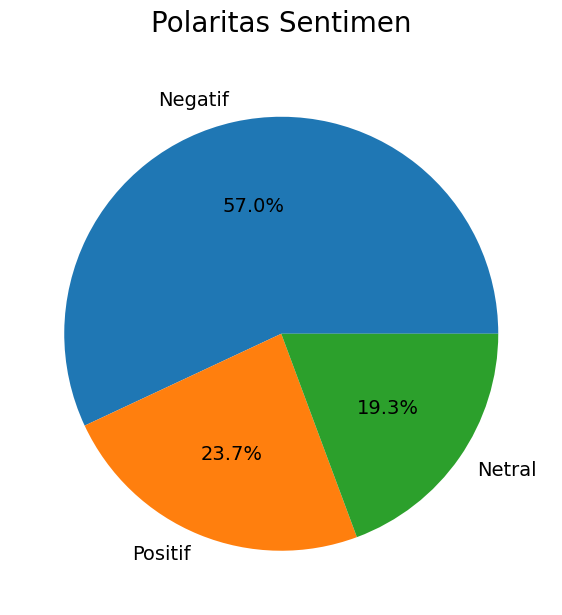

In [ ]:
fig, ax = plt.subplots(figsize=(7, 8))
sizes = [count for count in clean_df['polarity'].value_counts()]
#labels = list(clean_df['polarity'].value_counts().index)  # Mengambil nama kategori polaritas sentimen
labels = ['Negatif', 'Positif', 'Netral']
explode = (0, 0, 0)
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Polaritas Sentimen', fontsize=20, pad=22)
plt.show()

#Word Cloud

In [ ]:
positive_review = clean_df[clean_df['polarity'] == 'positive']
positive_review = positive_review[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
positive_review = positive_review.sort_values(by='polarity_score', ascending=False)
positive_review = positive_review.reset_index(drop=True)
positive_review.index += 1

In [ ]:
negative_review = clean_df[clean_df['polarity'] == 'negative']
negative_review = negative_review[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_review = negative_review.sort_values(by='polarity_score', ascending=False)
negative_review = negative_review.reset_index(drop=True)
negative_review.index += 1

In [ ]:
neutral_review = clean_df[clean_df['polarity'] == 'neutral']
neutral_review = neutral_review[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_review = neutral_review.sort_values(by='polarity_score', ascending=False)
neutral_review = neutral_review.reset_index(drop=True)
neutral_review.index += 1

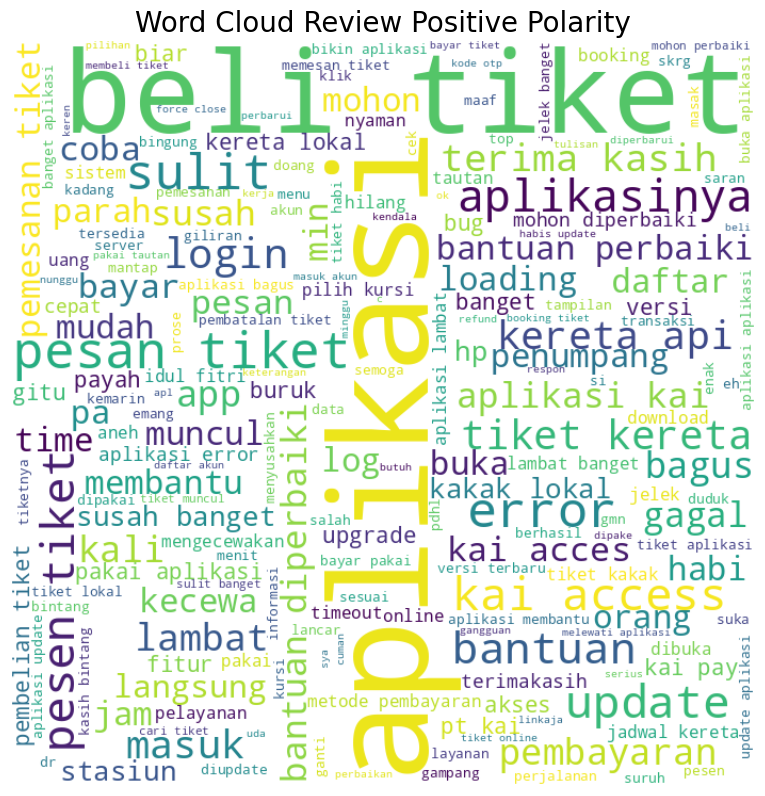

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gabungkan semua kata dari 'text_stopwords' menjadi satu string
list_words = ' '.join(clean_df['text_stopword'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x).tolist())

# Membuat Word Cloud dengan batasan jumlah kata
wordcloud = WordCloud(width=700, height=700, background_color='white', min_font_size=10, max_words=200).generate(list_words)

# Menampilkan Word Cloud
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Review Positive Polarity', fontsize=20)
ax.grid(False)
ax.imshow(wordcloud, interpolation='bilinear')
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

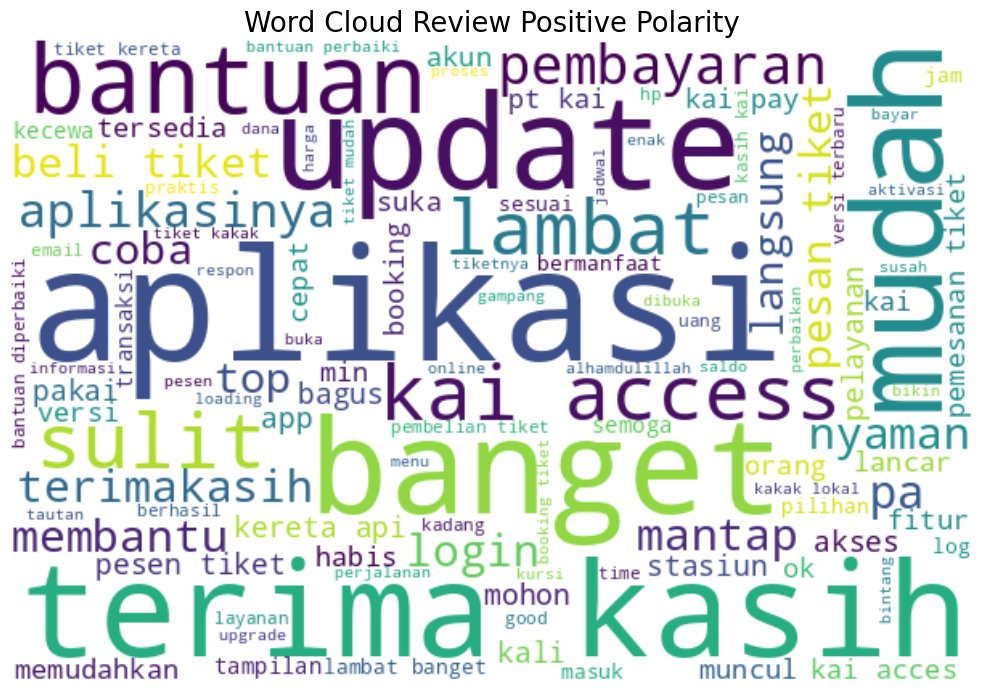

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gabungkan semua kata dari 'text_stopwords' menjadi satu string
list_words = ' '.join(positive_review['text_stopword'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x).tolist())

# Membuat Word Cloud dengan batasan jumlah kata
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10, max_words=200).generate(list_words)

# Menampilkan Word Cloud
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Review Positive Polarity', fontsize=20)
ax.grid(False)
ax.imshow(wordcloud, interpolation='bilinear')
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

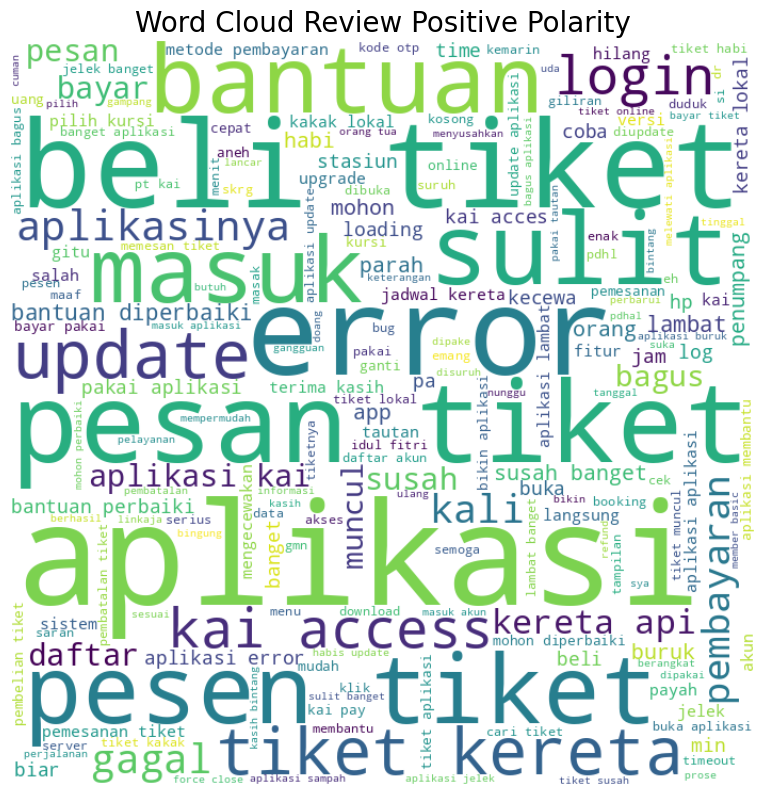

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gabungkan semua kata dari 'text_stopwords' menjadi satu string
list_words = ' '.join(negative_review['text_stopword'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x).tolist())

# Membuat Word Cloud dengan batasan jumlah kata
wordcloud = WordCloud(width=700, height=700, background_color='white', min_font_size=10, max_words=200).generate(list_words)

# Menampilkan Word Cloud
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Review Positive Polarity', fontsize=20)
ax.grid(False)
ax.imshow(wordcloud, interpolation='bilinear')
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

#Distribusi Kelas

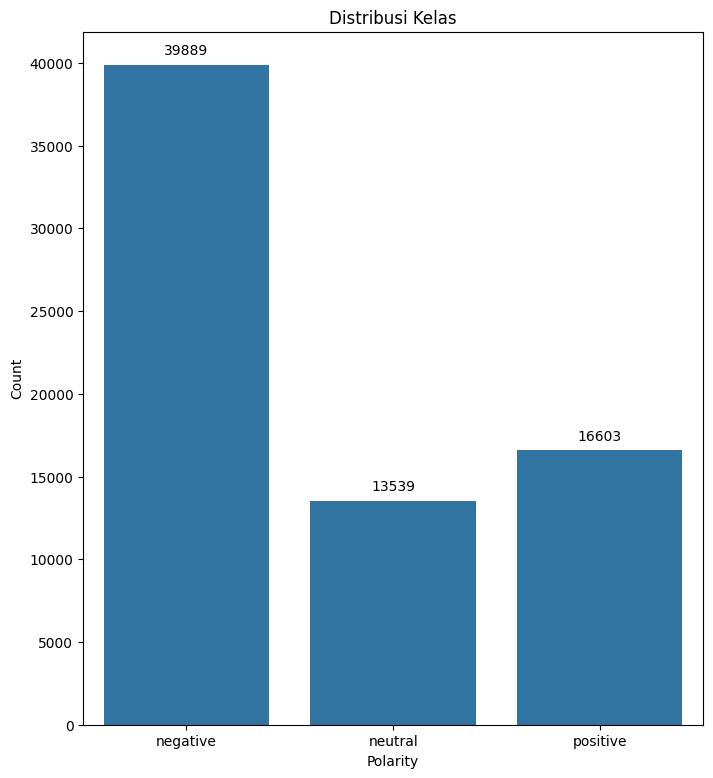

In [ ]:
# Mengatur ukuran gambar plot
plt.figure(figsize=(8, 9))

# Membuat plot count menggunakan seaborn untuk variabel 'polarity' dari dataframe 'clean_df'
class_dist_plot = sns.countplot(x='polarity', data=clean_df)

# Menetapkan judul plot
plt.title('Distribusi Kelas')

# Menetapkan label sumbu x
plt.xlabel('Polarity')

# Menetapkan label sumbu y
plt.ylabel('Count')

# Menambahkan label angka untuk setiap bar pada plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center',
                             xytext=(0, 10),
                             textcoords='offset points')

# Menampilkan plot
plt.show()

#Pemodelan

#Data Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=50)

#LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.8427102670284163
Logistic Regression - accuracy_test: 0.8395802098950524


#XGBoost

In [ ]:
# Mengonversi sparse matrix ke array
X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Membuat objek model XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42)

# Melatih model XGBoost pada data pelatihan
start_time = time.time()
xgb.fit(X_train_array, y_train_encoded)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_xgb = xgb.predict(X_train_array)
y_pred_test_xgb = xgb.predict(X_test_array)

# Evaluasi akurasi model XGBoost pada data pelatihan
accuracy_train_xgb = accuracy_score(y_pred_train_xgb, y_train_encoded)

# Evaluasi akurasi model XGBoost pada data uji
accuracy_test_xgb = accuracy_score(y_pred_test_xgb, y_test_encoded)

# Menampilkan akurasi dan waktu eksekusi
print('XGBoost - accuracy_train:', accuracy_train_xgb)
print('XGBoost - accuracy_test:', accuracy_test_xgb)
print('XGBoost - execution_time:', execution_time, 'seconds')

XGBoost - accuracy_train: 0.8603277166928459
XGBoost - accuracy_test: 0.8349396730206325
XGBoost - execution_time: 26.75401282310486 seconds


#CatBoost

In [ ]:
from catboost import CatBoostClassifier
import time

# Membuat objek model CatBoost
cat_model = CatBoostClassifier(n_estimators=100, random_state=42, verbose=0)

# Melatih model CatBoost pada data pelatihan
start_time = time.time()
cat_model.fit(X_train.toarray(), y_train)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_cat = cat_model.predict(X_train.toarray())
y_pred_test_cat = cat_model.predict(X_test.toarray())

# Evaluasi akurasi model CatBoost pada data pelatihan
accuracy_train_cat = accuracy_score(y_pred_train_cat, y_train)

# Evaluasi akurasi model CatBoost pada data uji
accuracy_test_cat = accuracy_score(y_pred_test_cat, y_test)

# Menampilkan akurasi dan waktu eksekusi
print('CatBoost - accuracy_train:', accuracy_train_cat)
print('CatBoost - accuracy_test:', accuracy_test_cat)
print('CatBoost - execution_time:', execution_time, 'seconds')


CatBoost - accuracy_train: 0.8429066114522348
CatBoost - accuracy_test: 0.8363675305204541
CatBoost - execution_time: 28.819703578948975 seconds


# SVM

In [ ]:
# Membuat objek model SVM
svm = SVC(kernel='linear')

# Melatih model SVM pada data pelatihan
start_time = time.time()
svm.fit(X_train.toarray(), y_train)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm.predict(X_train.toarray())
y_pred_test_svm = svm.predict(X_test.toarray())

# Evaluasi akurasi model SVM pada data pelatihan
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)

# Evaluasi akurasi model SVM pada data uji
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

# Menampilkan akurasi dan waktu eksekusi
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)
print('SVM - execution_time:', execution_time, 'seconds')

SVM - accuracy_train: 0.8411038126517207
SVM - accuracy_test: 0.8385093167701864
SVM - execution_time: 540.2237372398376 seconds


#Perbandingan Akurasi Model

In [43]:
# Membuat DataFrame untuk hasil akurasi
results_df = pd.DataFrame({
    'Model': ['Logistic Regression','Support Vector Machine','Extreme Gradient Boosting','Categorical Boosting'],
    'Accuracy Train': [accuracy_train_lr, accuracy_train_svm, accuracy_train_xgb, accuracy_train_cat],
    'Accuracy Test': [accuracy_test_lr, accuracy_test_svm, accuracy_test_xgb, accuracy_test_cat]
})

# Menampilkan hanya kolom "Accuracy Test"
accuracy_test_only = results_df[['Model','Accuracy Train', 'Accuracy Test']]

# Mengurutkan DataFrame berdasarkan kolom "Accuracy Test" dari tertinggi ke terendah
accuracy_test_sorted = accuracy_test_only.sort_values(by='Accuracy Test', ascending=False)

# Menampilkan DataFrame yang telah diurutkan
print(accuracy_test_sorted)

                       Model  Accuracy Train  Accuracy Test
0        Logistic Regression        0.842710       0.839580
1     Support Vector Machine        0.841104       0.838509
3       Categorical Boosting        0.842907       0.836368
2  Extreme Gradient Boosting        0.860328       0.834940


#Kesimpulan

In [44]:
# Simpan model SVM
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)

In [45]:
# Simpan TfidfVectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [46]:
!pip freeze > requirements.txt

In [47]:

!pip install Sastrawi
!pip install nltk
import pickle
from pickle import UnpicklingError
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import requests
import json
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
try:
    with open('/content/svm_model.pkl', 'rb') as f:
        svm = pickle.load(f)
except (EOFError, UnpicklingError) as e:
    print(f"Error loading xgb model: {e}")

    print("Check if 'svm_model.pkl' exists and is not empty.")
    print("If the file was transferred, ensure it was done in binary mode.")


try:
    with open('/content/tfidf_vectorizer.pkl', 'rb') as f:
        tfidf = pickle.load(f)
except (EOFError, UnpicklingError) as e:
    print(f"Error loading TF-IDF vectorizer: {e}")


def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word.lower() not in ["Access", "KAI ", "mobile"]])
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku','di','ya','loh','kah','deh'])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

def fix_slangwords(text):
    words = text.split()
    fixed_words = []
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
    fixed_text = ' '.join(fixed_words)
    return fixed_text

url = 'https://raw.githubusercontent.com/aninanandah/datasetproject/main/slangwords.json'  # URL tempat kamus slangwords disimpan

response = requests.get(url)

if response.status_code == 200:
    try:
        slangwords = json.loads(response.text)
    except json.JSONDecodeError as e:
        print("Error decoding JSON:", e)
        print("Response content:", response.text)
else:
    print("Failed to fetch data from URL. Status code:", response.status_code)

def preprocess_text(text):
    text = cleaningText(text)
    text = casefoldingText(text)
    text = fix_slangwords(text)
    text = tokenizingText(text)
    text = filteringText(text)
    text = toSentence(text)
    return text

def prediksi_sentimen_kalimat_baru(review_baru, tfidf, svm):

    review_baru_cleaned = cleaningText(review_baru)
    review_baru_casefolded = casefoldingText(review_baru_cleaned)
    review_baru_slangfixed = fix_slangwords(review_baru_casefolded)
    review_baru_tokenized = tokenizingText(review_baru_slangfixed)
    review_baru_filtered = filteringText(review_baru_tokenized)
    review_baru_final = toSentence(review_baru_filtered)


    X_review_baru = tfidf.transform([review_baru_final])


    X_review_baru = X_review_baru.toarray()


    prediksi_sentimen = svm.predict(X_review_baru)


    if prediksi_sentimen[0] == 'positive':
        hasil = "Sentimen review baru adalah POSITIF."
    elif prediksi_sentimen[0] == 'negative':
        hasil = "Sentimen review baru adalah NEGATIF."
    else:
        hasil = "Sentimen review baru adalah NETRAL."

    return hasil

In [49]:
review_baru = " terimakasih"
prediksi_sentimen_kalimat_baru(review_baru, tfidf, svm)

'Sentimen review baru adalah POSITIF.'

In [50]:
review_baru = " Sangat membantu, mudah"
prediksi_sentimen_kalimat_baru(review_baru, tfidf, svm)

'Sentimen review baru adalah POSITIF.'

In [51]:
review_baru = "sering ngelag"
prediksi_sentimen_kalimat_baru(review_baru, tfidf, svm)

'Sentimen review baru adalah NETRAL.'

In [52]:
review_baru = "sering eror"
prediksi_sentimen_kalimat_baru(review_baru, tfidf, svm)

'Sentimen review baru adalah NEGATIF.'